In [1]:
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
import coffea.hist as hist
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore', category=RuntimeWarning)

/opt/conda/lib/python3.8/site-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


In [50]:
fname_list = ['tt_Wb_qqb_numEvent100.root'] # change this if using other files
events_list = []

for fname in fname_list:
    events = NanoEventsFactory.from_root(fname, 
                                         treepath='mmtree/tree', 
                                         schemaclass=BaseSchema).events()
    events_list.append(events)
    
for field in events_list[0].fields:
    field_list = []
    for i in range(len(events_list)):
        field_list.append(events_list[i][field])
    locals()[field] = ak.concatenate(field_list, axis=0)
    
num_events = 0
for i in range(len(events_list)):
    num_events += len(events_list[i])

In [51]:
print(events.fields)

['fatjet_1_dr_T', 'fatjet_1_dr_T_Wq_max', 'fatjet_1_T_Wq_max_pdgId', 'fatjet_1_dr_W_daus', 'fatjet_1_dr_T_b', 'muon_pt', 'muon_eta', 'muon_trk_dxy', 'muon_trk_dz', 'muon_m', 'muon_charge', 'muon_type', 'muon_phi', 'fatjet_area', 'fatjet_eta', 'fatjet_n2b1', 'fatjet_n3b1', 'fatjet_phi', 'fatjet_pt', 'fatjet_mass', 'fatjet_msoftdrop', 'fatjet_mregressed', 'fatjet_doubleBTag', 'jet_pt', 'jet_eta', 'jet_phi', 'jet_m', 'jet_jetArea', 'jet_bTagScore', 'met_pt', 'met_phi']


In [52]:
# muon selection
muonmask = ((muon_pt > 20) 
            & (abs(muon_eta) < 2.5)
            & (abs(muon_trk_dxy) < 0.2)
#             & (abs(muon_trk_dz) < 5)
           )

goodevents = [True] * num_events
goodmuonevents = muon_pt[muonmask]
# print(goodmuonevents)

for i in range(num_events):
    if len(goodmuonevents[i]) != 1:
        goodevents[i] = False

print(goodevents)
noTrue = 0
for i in range(len(goodevents)):
    good = goodevents[i]
    if good:
        noTrue += 1
print(noTrue)

[True, False, True, False, False, False, True, False, False, True, False, False, False, False, True, False, False, False, False, True, False, True, False, True, True, False, False, False, False, True, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, True, True, False, False, False, False, False, True, False, True, False, False, False, False, False, True, False, False, True, False, False, False, False, False, False, True, False, False, False, True, False, False, False, False, True, True]
22


<AxesSubplot:xlabel='pT', ylabel='Events'>

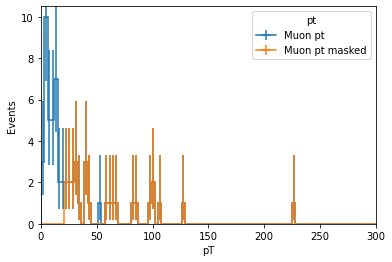

In [53]:
muon = hist.Hist('Events',
                 hist.Cat('sample', 'pt'),
                 hist.Bin('pt', 'pT', 100, 0, 300),
                )

muon.fill(sample='Muon pt', pt=ak.flatten(muon_pt))
muon.fill(sample='Muon pt masked', pt=ak.flatten(muon_pt[muonmask]))

hist.plot1d(muon, overlay='sample')

In [54]:
# met selection
for i in range(num_events):
    if met_pt[i] < 50:
        goodevents[i] = False
        
print(goodevents)
noTrue = 0
for i in range(len(goodevents)):
    good = goodevents[i]
    if good:
        noTrue += 1
print(noTrue)

[True, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, True, False, True, False, True, True, False, False, False, False, True, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, True, False, False, False, True, False, False, False, False, True, True]
15


<AxesSubplot:xlabel='pT', ylabel='Events'>

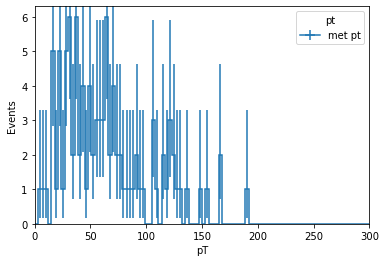

In [55]:
met = hist.Hist('Events',
                 hist.Cat('sample', 'pt'),
                 hist.Bin('pt', 'pT', 100, 0, 300),
                )

met.fill(sample='met pt', pt=met_pt)

hist.plot1d(met, overlay='sample')

In [56]:
from coffea.nanoevents.methods.vector import PtEtaPhiMLorentzVector
from coffea.nanoevents.methods import nanoaod

# leptonic W pt cut
ak.behavior.update(nanoaod.behavior)

mu = ak.zip({"pt": muon_pt,
                  "eta": muon_eta,
                  "phi": muon_phi,
                  "mass": muon_m},
                 with_name="PtEtaPhiMLorentzVector",)
met = ak.zip({"pt": met_pt,
                    "eta": None,
                    "phi": met_phi,
                    "mass": None},
                   with_name="PtEtaPhiMLorentzVector",)

leptonicW = met + mu
# print(leptonicW.pt[muonmask])

for i in range(num_events):
    if goodevents[i]:
#         print(leptonicW.pt[muonmask][i])
        if leptonicW.pt[muonmask][i] < 100.:
            goodevents[i] = False
        
print(goodevents)
noTrue = 0
for i in range(len(goodevents)):
    good = goodevents[i]
    if good:
        noTrue += 1
print(noTrue)

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, True, False, True, False, True, True, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
8


<AxesSubplot:xlabel='pT', ylabel='Events'>

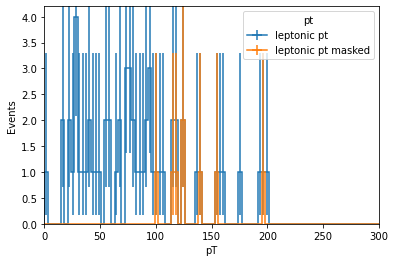

In [57]:
leptonic = hist.Hist('Events',
                 hist.Cat('sample', 'pt'),
                 hist.Bin('pt', 'pT', 100, 0, 300),
                )

leptonic.fill(sample='leptonic pt', pt=ak.flatten(leptonicW.pt))
leptonic.fill(sample='leptonic pt masked', pt=ak.flatten(leptonicW.pt[goodevents]))

hist.plot1d(leptonic, overlay='sample')

In [59]:
for i in range(num_events):
    if goodevents[i]:
        btag = False
        for j in range(len(jet_bTagScore[i])): # this many jets
            btagscore = jet_bTagScore[i][j]
            if btagscore < 100 and (abs(jet_phi[i][j] - muon_phi[i][0]) < 2.):
                btag = True
        if not btag:
            goodevents[i] = False
            
print(goodevents)
noTrue = 0
for i in range(len(goodevents)):
    good = goodevents[i]
    if good:
        noTrue += 1
print(noTrue)

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, True, False, True, False, True, True, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
8


In [60]:
# require fatjet away from the muon
probejets = {}
for i in range(num_events):
    if goodevents[i]:
        fatjetaway = False
        indices = []
        for j in range(len(fatjet_phi[i])): # this many fatjets
            if abs(fatjet_phi[i][j] - muon_phi[i][0]) > 2.:
                fatjetaway = True
                indices.append(j)
        probejets[i] = indices
        if not fatjetaway:
            goodevents[i] = False
            
print(goodevents)
noTrue = 0
for i in range(len(goodevents)):
    good = goodevents[i]
    if good:
        noTrue += 1
print(noTrue)

# keep only first fatjet
for i in probejets.keys():
    probejets[i] = probejets[i][0]
print(probejets) # key is the event index, value is the jet index of that event

eventprobes = list(probejets.keys())
jetprobes = list(probejets.values())
print(eventprobes)
print(jetprobes)

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, True, False, True, False, True, True, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
8
{14: 1, 19: 2, 21: 1, 23: 0, 24: 4, 32: 2, 64: 0, 79: 1}
[14, 19, 21, 23, 24, 32, 64, 79]
[1, 2, 1, 0, 4, 2, 0, 1]


{'fatjet_mass': array([0., 0., 0., 0., 0., 0., 0., 0.]), 'fatjet_pt': array([0., 0., 0., 0., 0., 0., 0., 0.])}
{'fatjet_mass': array([0., 0., 0., 0., 0., 0., 0., 0.]), 'fatjet_pt': array([0., 0., 0., 0., 0., 0., 0., 0.])}
{'fatjet_mass': array([ 16.58956528,  21.43977165,  67.06286621,  20.07754326,
        12.5704689 ,  23.43052483, 144.62786865,  37.32302475]), 'fatjet_pt': array([ 79.31388092,  78.855896  , 138.76737976, 134.56671143,
        40.26630783,  95.34659576, 473.88461304, 121.84066772])}


<AxesSubplot:xlabel='Mass', ylabel='Events'>

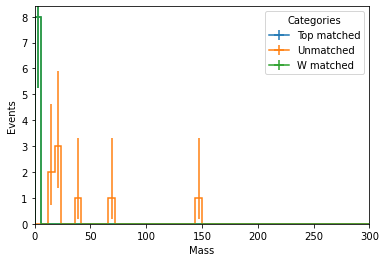

In [61]:
### change these 3 things if you want to plot different variables ###
var_list = [fatjet_mass, fatjet_pt]

var_names = ['fatjet_mass', 'fatjet_pt']

mass = hist.Hist('Events',
                 hist.Cat('sample', 'Categories'),
                 hist.Bin('mass', 'Mass', 50, 0, 300),
                 hist.Bin('pt', 'pT', 50, 0, 2000)
                )

###

topmatched = {}
Wmatched = {}
unmatched = {}

for name in var_names:
    topmatched[name] = np.zeros(len(eventprobes))
    Wmatched[name] = np.zeros(len(eventprobes))
    unmatched[name] = np.zeros(len(eventprobes))

for i in range(len(eventprobes)):
    eventprobe = eventprobes[i]
    jetprobe = jetprobes[i]
    
    fj_1_dr_T_b = fatjet_1_dr_T_b[eventprobe][jetprobe]
    fj_1_dr_T_Wq_max = fatjet_1_dr_T_Wq_max[eventprobe][jetprobe]
    fj_1_T_Wq_max_pdgId = fatjet_1_T_Wq_max_pdgId[eventprobe][jetprobe]
    fj_1_dr_W_daus = fatjet_1_dr_W_daus[eventprobe][jetprobe]
    jetR = 1.6 # check
    
    top = (fj_1_dr_T_b<jetR) & (fj_1_dr_T_Wq_max<jetR)
    W = ((fj_1_T_Wq_max_pdgId==0) & (fj_1_dr_W_daus<jetR)) or ((fj_1_T_Wq_max_pdgId!=0) & (fj_1_dr_T_b>=jetR) & (fj_1_dr_T_Wq_max<jetR))
    if top:
        for j in range(len(var_list)):
            var_name = var_names[j]
            var = var_list[j]
            var_value = var[eventprobe][jetprobe]
            topmatched[var_name][i] = var_value
    elif W:
        for j in range(len(var_list)):
            var_name = var_names[j]
            var = var_list[j]
            var_value = var[eventprobe][jetprobe]
            Wmatched[var_name][i] = var_value
    else:
        for j in range(len(var_list)):
            var_name = var_names[j]
            var = var_list[j]
            var_value = var[eventprobe][jetprobe]
            unmatched[var_name][i] = var_value

print(topmatched)
print(Wmatched)
print(unmatched)

### also change these! ###
mass.fill(sample='Top matched', mass=topmatched['fatjet_mass'], pt=topmatched['fatjet_pt'])
mass.fill(sample='W matched', mass=Wmatched['fatjet_mass'], pt=Wmatched['fatjet_pt'])
mass.fill(sample='Unmatched', mass=unmatched['fatjet_mass'], pt=unmatched['fatjet_pt'])

hist.plot1d(mass.sum('pt'), overlay='sample')
###